# I. Introduction
For every car dealers, selling new car does not bring them a lot of profit, selling used car does. With profit margin 20% up to 50%, this is the most important department and main financial focus for any dealer. Every car dealer has its own used car expert that could inspect and negotiate the car to get the best price, but there always be a chance of the car would not be sold and have to go through auction, which decrease a lot of profit. This project will build a model for car dealer to predict the sale price and listing time based on private car sell data from craiglist, with the goal is to cut off time for inspector and bring more profit for the company.

The data will be from Kaggle: https://www.kaggle.com/austinreese/craigslist-carstrucks-data

# II. EDA

### 1. Import

In [1]:
#Import library
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import datetime as dt

In [2]:
#Import data
vehicle_data = pd.read_csv('vehicles.csv', index_col=0)

In [3]:
vehicle_data.head()

id                                                url  region  \
0  7240372487  https://auburn.craigslist.org/ctd/d/auburn-uni...  auburn   
1  7240309422  https://auburn.craigslist.org/cto/d/auburn-201...  auburn   
2  7240224296  https://auburn.craigslist.org/cto/d/auburn-200...  auburn   
3  7240103965  https://auburn.craigslist.org/cto/d/lanett-tru...  auburn   
4  7239983776  https://auburn.craigslist.org/cto/d/auburn-200...  auburn   

                      region_url  price    year manufacturer  \
0  https://auburn.craigslist.org  35990  2010.0    chevrolet   
1  https://auburn.craigslist.org   7500  2014.0      hyundai   
2  https://auburn.craigslist.org   4900  2006.0          bmw   
3  https://auburn.craigslist.org   2000  1974.0    chevrolet   
4  https://auburn.craigslist.org  19500  2005.0         ford   

                  model  condition    cylinders  ... drive       size    type  \
0  corvette grand sport       good  8 cylinders  ...   rwd        NaN   other   
1                sonata  excellent  4 cylinders  ...   fwd        NaN   sedan   
2               x3 3.0i       good  6 cylinders  ...   NaN        NaN     SUV   
3                  c-10       good  4 cylinders  ...   rwd  full-size  pickup   
4           f350 lariat  excellent  8 cylinders  ...   4wd  full-size  pickup   

  paint_color                                          image_url  \
0         NaN  https://images.craigslist.org/00N0N_ipkbHVZYf4...   
1         NaN  https://images.craigslist.org/00s0s_gBHYmJ5o7y...   
2        blue  https://images.craigslist.org/00B0B_5zgEGWPOrt...   
3        blue  https://images.craigslist.org/00M0M_6o7KcDpArw...   
4        blue  https://images.craigslist.org/00p0p_b95l1EgUfl...   

                                         description state        lat  \
0  Carvana is the safer way to buy a car During t...    al  32.590000   
1  I'll move to another city and try to sell my c...    al  32.547500   
2  Clean 2006 BMW X3 3.0I.  Beautiful and rare Bl...    al  32.616807   
3  1974 chev. truck (LONG BED) NEW starter front ...    al  32.861600   
4  2005 Ford F350 Lariat (Bullet Proofed). This t...    al  32.547500   

        long              posting_date  
0 -85.480000  2020-12-02T08:11:30-0600  
1 -85.468200  2020-12-02T02:11:50-0600  
2 -85.464149  2020-12-01T19:50:41-0600  
3 -85.216100  2020-12-01T15:54:45-0600  
4 -85.468200  2020-12-01T12:53:56-0600  

[5 rows x 25 columns]

In [4]:
vehicle_data.head(1).T

0
id                                                   7240372487
url           https://auburn.craigslist.org/ctd/d/auburn-uni...
region                                                   auburn
region_url                        https://auburn.craigslist.org
price                                                     35990
year                                                       2010
manufacturer                                          chevrolet
model                                      corvette grand sport
condition                                                  good
cylinders                                           8 cylinders
fuel                                                        gas
odometer                                                  32742
title_status                                              clean
transmission                                              other
VIN                                           1G1YU3DW1A5106980
drive                                                       rwd
size                                                        NaN
type                                                      other
paint_color                                                 NaN
image_url     https://images.craigslist.org/00N0N_ipkbHVZYf4...
description   Carvana is the safer way to buy a car During t...
state                                                        al
lat                                                       32.59
long                                                     -85.48
posting_date                           2020-12-02T08:11:30-0600

There are 25 columns for each data, and most of useful data for our prediction is here. However one of the most important data is listing time or selling date is missing, which potentially bring us to two options: to remove the listing time feature altogether, or to find another data to predict listing time.

There are a few columns that are not really useful, such as url, region_url, image_url, lat, long (listing place?). We will drop all these columns to make the data more relevant to what we need

In [5]:
vehicle_data[['state', 'region']][vehicle_data.state != vehicle_data.region].count()


state     458213
region    458213
dtype: int64

In [6]:
vehicle_data_cleaned = vehicle_data.drop(axis=1, columns=['url', 'region_url', 'image_url', 'id'])

In [7]:
vehicle_data_cleaned.head(1).T

0
region                                                   auburn
price                                                     35990
year                                                       2010
manufacturer                                          chevrolet
model                                      corvette grand sport
condition                                                  good
cylinders                                           8 cylinders
fuel                                                        gas
odometer                                                  32742
title_status                                              clean
transmission                                              other
VIN                                           1G1YU3DW1A5106980
drive                                                       rwd
size                                                        NaN
type                                                      other
paint_color                                                 NaN
description   Carvana is the safer way to buy a car During t...
state                                                        al
lat                                                       32.59
long                                                     -85.48
posting_date                           2020-12-02T08:11:30-0600

Now we will check how good the data is, probably by checking the missing data in each column.

In [8]:
missing = pd.concat([vehicle_data_cleaned.isnull().sum(), 100 * vehicle_data_cleaned.isnull().mean()], axis=1)
missing.columns = (['count', '%'])
missing.sort_values('%')

count          %
region             0   0.000000
price              0   0.000000
state              0   0.000000
posting_date      28   0.006111
description       70   0.015277
year            1050   0.229151
transmission    2442   0.532940
title_status    2577   0.562402
fuel            3237   0.706440
model           4846   1.057587
long            7448   1.625445
lat             7448   1.625445
manufacturer   18220   3.976317
odometer       55303  12.069278
type          112738  24.603841
drive         134188  29.285070
paint_color   140843  30.737452
cylinders     171140  37.349442
VIN           187549  40.930528
condition     192940  42.107055
size          321348  70.130703

Missing 70% size, 42% condition, 40% VIN, 37% cylinders, 30% paint color. We can drop the VIN column since it's not really necessary. Will keep the size for now and see if it brings any useful trend.

In [9]:
vehicle_data_cleaned.drop(axis=1, inplace=True, columns=['VIN', 'size'])

In [10]:
vehicle_data_cleaned[vehicle_data.price == 0].head()

region  price    year manufacturer                  model  condition  \
25       auburn      0  2016.0    chevrolet  silverado 1500 lt z71        NaN   
42       auburn      0  2014.0          ram                    NaN        NaN   
171  birmingham      0  2014.0          NaN  Freightliner Cascadia        NaN   
325  birmingham      0  2019.0          NaN          Biz On Wheels  excellent   
326  birmingham      0  2019.0          NaN          Biz On Wheels  excellent   

       cylinders    fuel  odometer title_status transmission drive   type  \
25   8 cylinders   other   29458.0      missing    automatic   4wd  truck   
42           NaN  diesel       0.0        clean    automatic   NaN  other   
171          NaN  diesel    1000.0        clean    automatic   NaN    NaN   
325          NaN     gas       0.0        clean    automatic   NaN    NaN   
326          NaN     gas       0.0        clean    automatic   NaN    NaN   

    paint_color                                        description state  \
25        white  ROGER BELL AUTO BROKERS  At Roger Bell Auto Br...    al   
42        white  All Trucks USA12106 Old River RdRockton, IL 61...    al   
171         NaN  HEC Leasing Call Russ or Gary at 888-366-1571 ...    al   
325         NaN  2019 *** Biz On Wheels   ***    Ready To Upgra...    al   
326         NaN  2019 *** Biz On Wheels   ***    Ready To Upgra...    al   

           lat       long              posting_date  
25   33.151200 -85.372200  2020-11-21T09:52:03-0600  
42         NaN        NaN  2020-11-17T14:55:59-0600  
171  36.012700 -86.560000  2020-12-01T15:21:49-0600  
325  35.240404 -80.901674  2020-11-29T09:45:48-0600  
326  35.240404 -80.901674  2020-11-29T09:45:26-0600

In [11]:
vehicle_data_cleaned[['manufacturer', 'price', 'description']].sort_values('price', ascending=False).head(30)

manufacturer       price  \
385434      chevrolet  3615215112   
425188           jeep  2857993261   
38375             gmc  2808348671   
1622        chevrolet  1234567890   
414603           ford   123456789   
306217            ram   123456789   
339197      chevrolet   123456789   
339213           jeep   123456789   
326182       chrysler   123456789   
414605            NaN   123456789   
393667            NaN   100000000   
238861           ford    98504250   
191736       cadillac    79000000   
362163       cadillac    50000000   
174403         toyota    22000000   
145053           jeep    12345679   
256573         toyota    12345678   
25413          nissan    11111111   
360640      chevrolet    11111111   
109654            NaN    11111111   
107009  mercedes-benz     9999999   
191738       cadillac     7900000   
109428           jeep     3429900   
370801       chrysler     2015200   
190027            NaN     1234567   
151323           jeep     1234567   
21955       chevrolet     1234567   
267603      chevrolet     1234567   
369909      chevrolet     1234567   
384531      chevrolet     1234567   

                                              description  
385434  2006 Chevrolet Silverado 2500 HD 4x4 LBZ low m...  
425188  2003 jeep 4dr  allpower rwd 6 cyl runs and dri...  
38375   WILL BUY YOU RLIFTED OR LOWERED TRUCK , SINGLE...  
1622    For Sale or Trade ??(BUT TRADE IS HIGHER )I ha...  
414603  2002 Eplorer 135000 miles.New tune up.Air filt...  
306217  2018 Ram 3500 Tradesman. Manual transmission. ...  
339197  Hi everyone! We are looking to buy classic car...  
339213  Looking to buy jeeps! Wranglers 1985 to 2020! ...  
326182  1939 chrysler royal 4 dr. Needs some paint and...  
414605  2006 Navagater Best offer.148000 miles. I boug...  
393667  SOLD  🍻( Very Nice )) 1961 Corvette  beautiful...  
238861  2008 Ford Ranger  (4x4) Manual Transmission (5...  
191736  Liquidating 30 perfectly rest  pre 70 classic ...  
362163  Not 50 mill but reasonably priced. Selling 30 ...  
174403  Nice reliable truck. Bought while living in Fl...  
145053  I search the country for Top shelf Jeeps , The...  
256573  condition: good make / manufacturer: toyota mo...  
25413   Both of them run and registered 150k miles on ...  
360640  CASH TODAY FOR ANTIQUE/CLASSIC CARS, 1955-1957...  
109654  CLASSIC CAR-TRUCK-BIKE WANTED ASAP -   I AM LO...  
107009  ESTABLISH FOR ALMOST 30 YEARS. ALWAYS A BUY HE...  
191738  Liquidating  30 perfectly rest  pre 70 classic...  
109428  2017 *Jeep* *Wrangler Unlimited* Sport 4x4 SUV...  
370801  DISCOVERY AUTO SALES 8140 N Lamar Austin TX 78...  
190027  PLEASE READ THE WHOLE POST BEFORE CONTACTING M...  
151323  Top shelf jeeps,  have around 25 in stock, Onl...  
21955   37TH ANNUAL NATIONALLY ADVERTISED TEXAS SWAP M...  
267603  You will have to tittle this car.  Now for the...  
369909  37TH ANNUAL NATIONALLY ADVERTISED TEXAS SWAP M...  
384531  37TH ANNUAL NATIONALLY ADVERTISED TEXAS SWAP M...

Many prices don't make sense. Except the Ferrari, other cars should not be higher than $500,000. From the description, these are either typo or car dealers promotion. price > mean + 2*std

In [12]:
vehicle_data.price.mean() + 2 * vehicle_data.price.std()

16429618.1380259

In [13]:
vehicle_data_cleaned[vehicle_data_cleaned.price > 600000].shape

(55, 19)

In [14]:
vehicle_data_cleaned = vehicle_data_cleaned.drop(vehicle_data_cleaned[(vehicle_data_cleaned.price > 600000) & (vehicle_data_cleaned.price < 1000)].index)
vehicle_data_cleaned = vehicle_data_cleaned.drop(vehicle_data_cleaned[vehicle_data_cleaned.manufacturer.isnull()].index)
vehicle_data_cleaned = vehicle_data_cleaned.drop(vehicle_data_cleaned[(vehicle_data_cleaned.manufacturer != 'ferrari') & (vehicle_data_cleaned.price > 100000)].index)
vehicle_data_cleaned = vehicle_data_cleaned.drop(vehicle_data_cleaned[(vehicle_data_cleaned.manufacturer == 'toyota') & (vehicle_data_cleaned.price > 90000)].index)
vehicle_data_cleaned = vehicle_data_cleaned.drop_duplicates(subset = ['region', 'price', 'year', 'manufacturer', 'model', 'condition', 'odometer'])
vehicle_data_cleaned['year'] = pd.to_datetime(vehicle_data_cleaned['year'], format='%Y')
vehicle_data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 385257 entries, 0 to 458211
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   region        385257 non-null  object        
 1   price         385257 non-null  int64         
 2   year          385254 non-null  datetime64[ns]
 3   manufacturer  385257 non-null  object        
 4   model         381002 non-null  object        
 5   condition     231746 non-null  object        
 6   cylinders     245433 non-null  object        
 7   fuel          382793 non-null  object        
 8   odometer      343077 non-null  float64       
 9   title_status  383322 non-null  object        
 10  transmission  383381 non-null  object        
 11  drive         274582 non-null  object        
 12  type          293735 non-null  object        
 13  paint_color   270655 non-null  object        
 14  description   385215 non-null  object        
 15  state         385

In [40]:
%load_ext autoreload
%autoreload 2
import pandas_profiling
report = vehicle_data_cleaned.profile_report(sort='None', html={'style':{'full_width': True}}, progress_bar=False)
report

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
vehicle_data_by_state = vehicle_data_cleaned.groupby(['state']).agg(
    mean_price = pd.NamedAgg(column='price', aggfunc='mean'),
    number_of_sale = pd.NamedAgg(column='state', aggfunc='count')
).reset_index()
vehicle_data_by_state['mean_price'] = vehicle_data_by_state['mean_price'].round()
vehicle_data_by_state['state'] = vehicle_data_by_state['state'].str.upper()
vehicle_data_by_state = vehicle_data_by_state.sort_values('number_of_sale')
vehicle_data_by_state

state  mean_price  number_of_sale
28    ND     15123.0             480
8     DE     14109.0             866
49    WV     18830.0             867
44    UT     18440.0             943
50    WY     21699.0             969
29    NE     15263.0            1280
25    MS     13110.0            1341
41    SD     14909.0            1478
46    VT     13902.0            1901
39    RI     13627.0            2226
21    ME     12214.0            2312
30    NH     14074.0            2366
11    HI     15826.0            2503
7     DC     13379.0            2634
33    NV     16204.0            2698
0     AK     19094.0            2895
18    LA     14650.0            2958
2     AR     13898.0            3421
32    NM     16232.0            3755
20    MD     15095.0            3835
17    KY     15709.0            4112
24    MO     13890.0            4565
1     AL     16682.0            4804
6     CT     12209.0            4884
26    MT     19109.0            5520
16    KS     15172.0            5560
36    OK     14630.0            5730
40    SC     14188.0            6308
15    IN     16113.0            6328
10    GA     14317.0            6495
19    MA     13372.0            7273
13    ID     17388.0            7527
3     AZ     15752.0            7769
12    IA     12712.0            8055
23    MN     13320.0            8140
31    NJ     14329.0            8808
14    IL     13312.0            9412
45    VA     11483.0            9421
42    TN     15844.0            9932
5     CO     15223.0           10722
47    WA     18988.0           11032
48    WI     13958.0           11317
38    PA     13985.0           11478
37    OR     13371.0           13883
27    NC     12824.0           14617
35    OH     13709.0           15596
22    MI     13061.0           17199
34    NY     13621.0           17374
43    TX     16119.0           20904
9     FL     14923.0           24783
4     CA     15897.0           43981

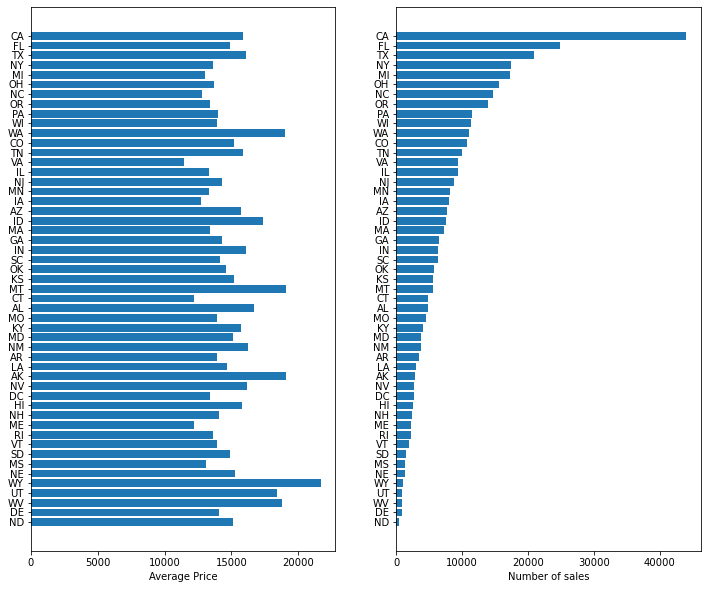

In [39]:
y1 = vehicle_data_by_state['mean_price']
y2 = vehicle_data_by_state['number_of_sale']
x = vehicle_data_by_state['state']
fig, axs = plt.subplots(1, 2, figsize=(12,10))
axs[0].barh(x, y1)
axs[0].set_xlabel('Average Price')
axs[1].barh(x, y2);
axs[1].set_xlabel('Number of sales');

In [17]:
vehicle_data_by_year = vehicle_data_cleaned.groupby('year')[['price']].mean().round()
vehicle_data_by_year['count'] = vehicle_data_cleaned.groupby('year')[['price']].count()
vehicle_data_by_year = vehicle_data_by_year.sort_values('year').reset_index()
vehicle_data_by_year.columns = ['year', 'mean_price', 'num_of _sale']
vehicle_data_by_year.sort_values('year', ascending=False).head()
#vehicle_data_by_year[['mean_price']][vehicle_data_by_year.year == 2020]

year  mean_price  num_of _sale
106 2021-01-01     34362.0           541
105 2020-01-01     31576.0          8248
104 2019-01-01     25957.0         20770
103 2018-01-01     23936.0         23537
102 2017-01-01     22075.0         36207

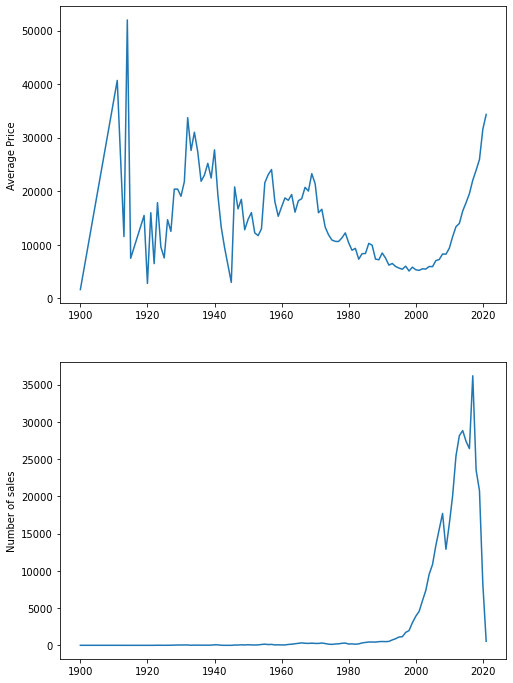

In [18]:
y1 = vehicle_data_by_year['mean_price']
y2 = vehicle_data_by_year['num_of _sale']
x = vehicle_data_by_year.year
fig, axs = plt.subplots(2, 1, figsize=(8, 12))
axs[0].plot(x, y1)
axs[0].set_ylabel('Average Price')
axs[1].plot(x, y2)
axs[1].set_ylabel('Number of sales');

In [19]:
vehicle_data_by_manufacturer = vehicle_data_cleaned.groupby('manufacturer')[['price']].mean().round()
vehicle_data_by_manufacturer['count'] = vehicle_data_cleaned.groupby('manufacturer')[['price']].count()
vehicle_data_by_manufacturer = vehicle_data_by_manufacturer.sort_values('price').reset_index()
vehicle_data_by_manufacturer.columns = ['manufacturer', 'mean_price', 'num_sale']
vehicle_data_by_manufacturer

manufacturer  mean_price  num_sale
0            saturn      3619.0      1223
1           mercury      4688.0      1444
2           pontiac      6837.0      2722
3          chrysler      8355.0      6477
4           hyundai      8360.0      9378
5        mitsubishi      9214.0      1985
6             honda      9412.0     22497
7               kia      9480.0      7497
8             buick      9597.0      5275
9             mazda     10195.0      5313
10           nissan     10340.0     20428
11       volkswagen     10442.0      9429
12             fiat     10613.0       868
13            acura     10887.0      3551
14             mini     11523.0      2152
15            volvo     11667.0      2557
16           datsun     11903.0        62
17           subaru     12502.0      9371
18          lincoln     12582.0      2938
19            dodge     12660.0     14498
20  harley-davidson     13062.0       103
21       land rover     13426.0        18
22           toyota     13969.0     34014
23         infiniti     13994.0      3319
24        chevrolet     15974.0     56751
25         cadillac     16181.0      5923
26            lexus     16356.0      6415
27             ford     16456.0     69235
28              bmw     16813.0     11080
29             jeep     16885.0     18630
30    mercedes-benz     18445.0      9411
31             audi     18531.0      4998
32           jaguar     19356.0       990
33              gmc     20030.0     15078
34       alfa-romeo     22493.0       176
35              ram     23735.0     15270
36            rover     25419.0      1480
37          porsche     31329.0      1589
38        hennessey     35000.0         1
39     aston-martin     38062.0        28
40            tesla     39870.0       988
41           morgan     80985.0         3
42          ferrari    145848.0        92

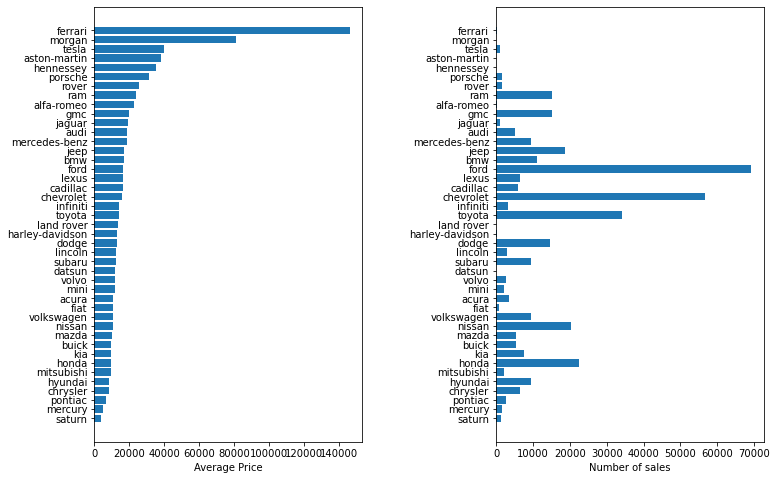

In [20]:
y1 = vehicle_data_by_manufacturer['mean_price']
y2 = vehicle_data_by_manufacturer['num_sale']
x = vehicle_data_by_manufacturer.manufacturer
fig, axs = plt.subplots(1, 2, figsize=(12,8))
axs[0].barh(x, y1)
axs[0].set_xlabel('Average Price')
axs[1].barh(x, y2)
axs[1].set_xlabel('Number of sales')
plt.subplots_adjust(wspace= 0.5);

In [21]:
vehicle_data_by_odometer = vehicle_data_cleaned.groupby('odometer').agg(
    mean_price = pd.NamedAgg(column='price', aggfunc='mean'),
    number_of_sale = pd.NamedAgg(column='price', aggfunc='count'))
vehicle_data_by_odometer = vehicle_data_by_odometer.reset_index()
right_outline = vehicle_data_by_odometer.odometer.mean() + 2* vehicle_data_by_odometer.odometer.std()
right_outline

12703292.655472226

In [22]:
vehicle_data_by_odometer = vehicle_data_by_odometer.drop(vehicle_data_by_odometer[vehicle_data_by_odometer.odometer > 900000].index)
vehicle_data_by_odometer.tail()

odometer  mean_price  number_of_sale
105761  870000.0     19500.0               1
105762  871333.0       950.0               1
105763  880000.0      6200.0               1
105764  888999.0       900.0               1
105765  900000.0      6000.0               1

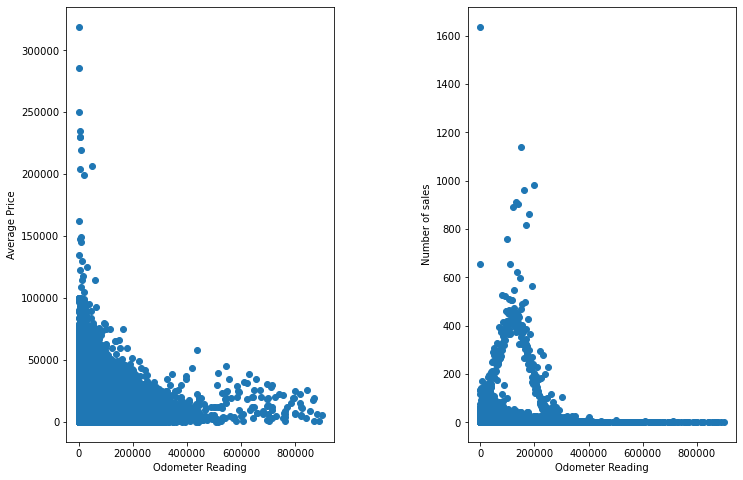

In [23]:
y1 = vehicle_data_by_odometer['mean_price']
y2 = vehicle_data_by_odometer['number_of_sale']
x = vehicle_data_by_odometer.odometer
fig, axs = plt.subplots(1, 2, figsize=(12,8))
axs[0].scatter(x, y1)
axs[0].set_ylabel('Average Price')
axs[1].scatter(x, y2)
axs[1].set_ylabel('Number of sales')
axs[0].set_xlabel('Odometer Reading')
axs[1].set_xlabel('Odometer Reading')
plt.subplots_adjust(wspace= 0.5);

In [24]:
vehicle_data_by_fuel = vehicle_data_cleaned.groupby(['fuel']).agg(
    mean_price = pd.NamedAgg(column='price', aggfunc='mean'),
    number_of_sale = pd.NamedAgg(column='price', aggfunc='count'))
vehicle_data_by_fuel = vehicle_data_by_fuel.reset_index().sort_values('mean_price')
vehicle_data_by_fuel

fuel    mean_price  number_of_sale
3    hybrid  11357.582238            4943
2       gas  13791.145446          339494
4     other  19430.063744           13115
1  electric  24482.331700            2041
0    diesel  26012.389224           23200

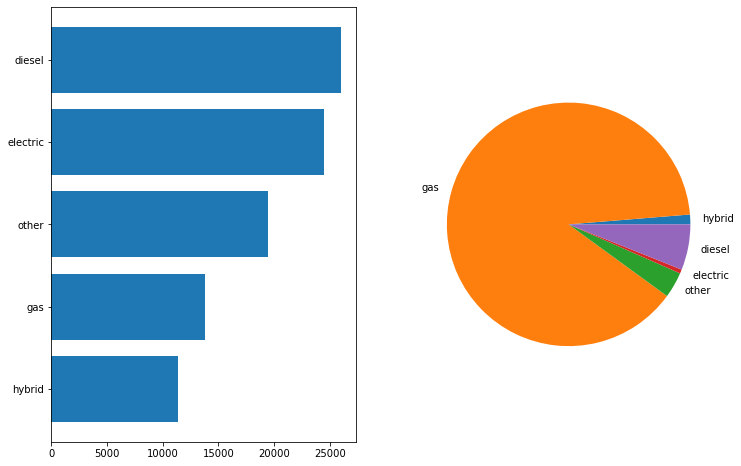

In [25]:


y1 = vehicle_data_by_fuel.mean_price
y2 = vehicle_data_by_fuel.number_of_sale
x = vehicle_data_by_fuel.fuel
fig, axs = plt.subplots(1, 2, figsize=(12,8))
axs[0].barh(x, y1)

axs[1].pie(y2, labels=x);

In [26]:
vehicle_data_by_color = vehicle_data_cleaned.groupby('paint_color').agg(
    mean_price = pd.NamedAgg(column='price', aggfunc='mean'),
    number_of_sale = pd.NamedAgg(column='price', aggfunc='count'))
vehicle_data_by_color = vehicle_data_by_color.sort_values('mean_price').reset_index()
vehicle_data_by_color

paint_color    mean_price  number_of_sale
0        green   9694.407669            6233
1        brown  11623.525692            5235
2       purple  12454.380216             647
3       silver  13260.606828           40130
4       yellow  13628.647177            1488
5         grey  13670.570321           26322
6       custom  13736.115996            7233
7         blue  13807.355546           28137
8          red  16232.754276           28882
9        white  17350.772777           69139
10       black  17434.931536           55577
11      orange  17696.640319            1632

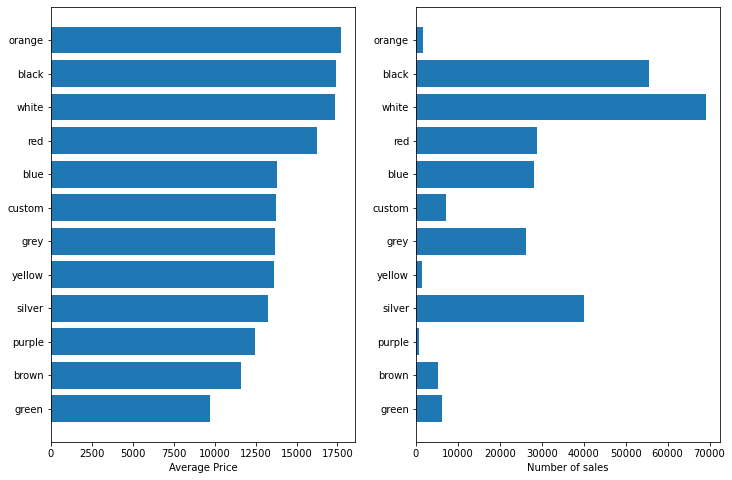

In [27]:
y1 = vehicle_data_by_color.mean_price
y2 = vehicle_data_by_color.number_of_sale
x = vehicle_data_by_color.paint_color

fig, axs = plt.subplots(1, 2, figsize=(12,8))

axs[0].barh(x, y1)
axs[0].set_xlabel('Average Price')
axs[1].barh(x, y2)
axs[1].set_xlabel('Number of sales');

In [28]:
vehicle_data_by_type = vehicle_data_cleaned.groupby('type').agg(
    mean_price = pd.NamedAgg(column='price', aggfunc='mean'),
    number_of_sale = pd.NamedAgg(column='price', aggfunc='count'))
vehicle_data_by_type = vehicle_data_by_type.sort_values('mean_price').reset_index()
vehicle_data_by_type

type    mean_price  number_of_sale
0      mini-van   8687.252397            5424
1         sedan  10465.400089           78875
2     hatchback  10973.214501           14592
3         wagon  11419.827734            8661
4           SUV  13765.969258           67107
5           van  14426.355231            8296
6           bus  14868.152284             394
7       offroad  16247.211268             568
8   convertible  17419.364426            5639
9         coupe  18952.502222           16425
10        truck  19670.477732           29257
11        other  21710.073368           20554
12       pickup  24858.128614           37943

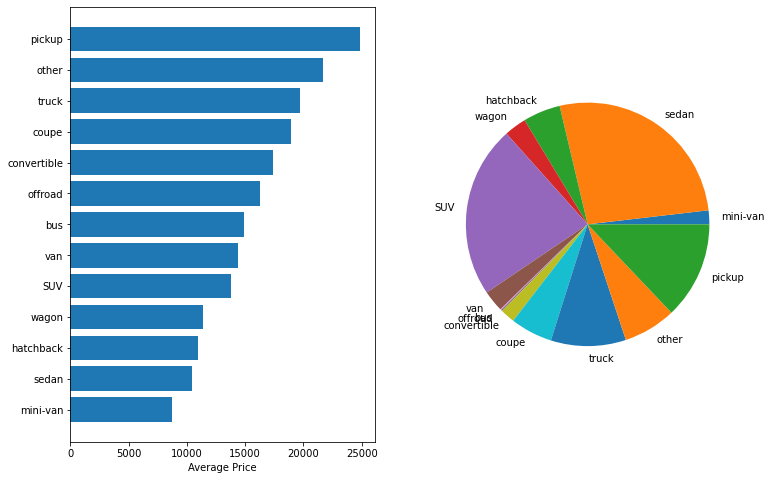

In [29]:
y1 = vehicle_data_by_type.mean_price
y2 = vehicle_data_by_type.number_of_sale
x = vehicle_data_by_type.type

fig, axs = plt.subplots(1, 2, figsize=(12,8))

axs[0].barh(x, y1)
axs[0].set_xlabel('Average Price')
axs[1].pie(y2, labels=x);

In [30]:
vehicle_data_by_title = vehicle_data_cleaned.groupby('title_status').agg(
    mean_price = pd.NamedAgg(column='price', aggfunc='mean'),
    number_of_sale = pd.NamedAgg(column='price', aggfunc='count'))
vehicle_data_by_title = vehicle_data_by_title.sort_values('mean_price').reset_index()
vehicle_data_by_title

title_status    mean_price  number_of_sale
0   parts only   1765.444444             153
1      missing   4283.519793             581
2      salvage   9283.249669            3777
3      rebuilt  10925.262280            7736
4        clean  14904.843829          369127
5         lien  20842.723819            1948

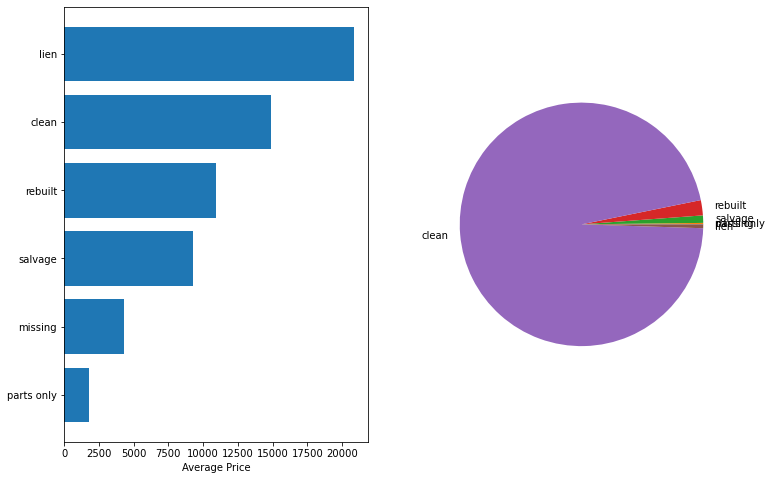

In [31]:
y1 = vehicle_data_by_title.mean_price
y2 = vehicle_data_by_title.number_of_sale
x = vehicle_data_by_title.title_status

fig, axs = plt.subplots(1, 2, figsize=(12,8))

axs[0].barh(x, y1)
axs[0].set_xlabel('Average Price')
axs[1].pie(y2, labels=x);

In [32]:
vehicle_data_by_drive = vehicle_data_cleaned.groupby('drive').agg(
    mean_price = pd.NamedAgg(column='price', aggfunc='mean'),
    number_of_sale = pd.NamedAgg(column='price', aggfunc='count'))
vehicle_data_by_drive = vehicle_data_by_drive.sort_values('mean_price').reset_index()
vehicle_data_by_drive

drive    mean_price  number_of_sale
0   fwd   9450.208341          103974
1   rwd  17281.195981           52056
2   4wd  19435.907138          118552

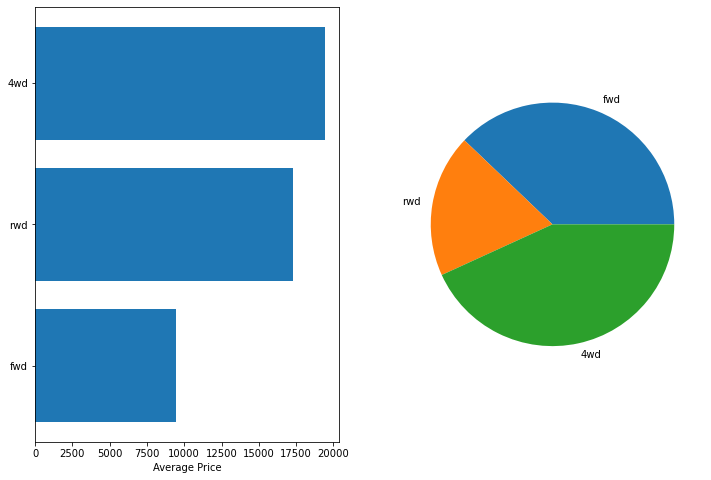

In [33]:
y1 = vehicle_data_by_drive.mean_price
y2 = vehicle_data_by_drive.number_of_sale
x = vehicle_data_by_drive.drive

fig, axs = plt.subplots(1, 2, figsize=(12,8))

axs[0].barh(x, y1)
axs[0].set_xlabel('Average Price')
axs[1].pie(y2, labels=x);

In [34]:
vehicle_data_by_transmission = vehicle_data_cleaned.groupby('transmission').agg(
    mean_price = pd.NamedAgg(column='price', aggfunc='mean'),
    number_of_sale = pd.NamedAgg(column='price', aggfunc='count'))
vehicle_data_by_transmission = vehicle_data_by_transmission.sort_values('mean_price').reset_index()
vehicle_data_by_transmission

transmission    mean_price  number_of_sale
0       manual  12200.147951           22129
1    automatic  14063.980942          331572
2        other  24430.883120           29680

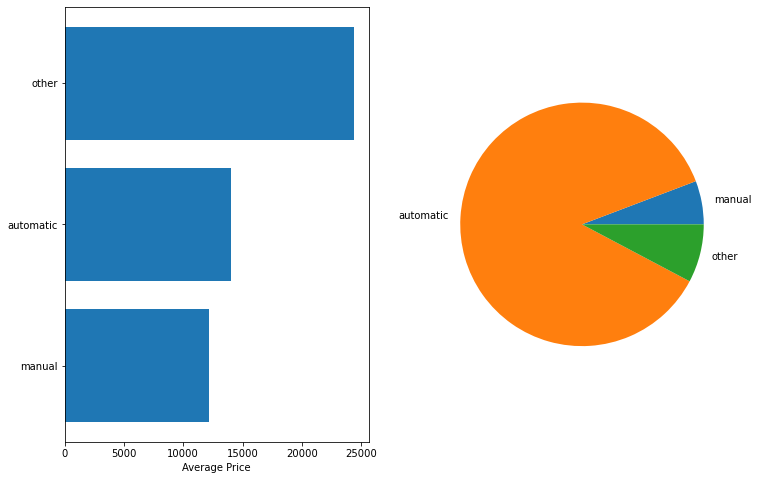

In [35]:
y1 = vehicle_data_by_transmission.mean_price
y2 = vehicle_data_by_transmission.number_of_sale
x = vehicle_data_by_transmission.transmission

fig, axs = plt.subplots(1, 2, figsize=(12,8))

axs[0].barh(x, y1)
axs[0].set_xlabel('Average Price')
axs[1].pie(y2, labels=x);

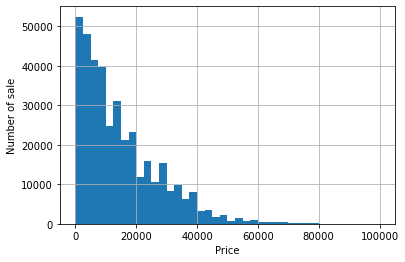

In [55]:
vehicle_data_cleaned.price[vehicle_data_cleaned.price < 100000].hist(bins=40)
plt.xlabel('Price')
plt.ylabel('Number of sale');

In [48]:
vehicle_data_cleaned.price.sort_values(ascending=False)

190054    625000
189676    389500
190011    325000
390793    319000
53582     285888
           ...  
387034         0
314398         0
29689          0
29690          0
332592         0
Name: price, Length: 385257, dtype: int64

- Change year to age - better info
- Change category columns such as type, drive, fuel, etc. to single columns with yes/no value?